In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'../data/interim/diabetic_readmission_data_interim.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_general
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3.0,Missing,...,Up,No,No,No,No,No,Ch,Yes,>30,1
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2.0,Missing,...,No,No,No,No,No,No,No,Yes,NO,0
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2.0,Missing,...,Up,No,No,No,No,No,Ch,Yes,NO,0
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1.0,Missing,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
4,55842,84259809,Caucasian,Male,[60-70),3,1,2,4.0,Missing,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


Target variable was encoded ordinally with 0 being not readmitted, 1 being readmitted within the first month and 2 afterwards. After several tries, due to the imbalanced nature of the data, we found the best performing algorithm by training two models: one model   to predict whether the patient will be readmitted or not and the second one is going to predict if the readmission will be before or after the 30 days. For this we use the already created new target for the first model "readmitted_general".

In [3]:
#Target variable
encode = {'NO': 0,
          '<30': 1,
          '>30': 2}

df['readmitted'] = df['readmitted'].map(encode)
df['readmitted'] = df['readmitted'].astype(int)

Features with two distinct values such as diabetesMed and change (basically "Yes" and "No") were binary encoded: "Yes" = 1 and "No" = 0

In [4]:
#diabetesMed variable
encode = {'No': 0,
          'Yes': 1}

df['diabetesMed'] = df['diabetesMed'].replace(encode)

#change variable
encode = {'No': 0,
          'Ch': 1}

df['change'] = df['change'].replace(encode)

#gender variable
encode = {'Male': 0,
          'Female': 1}

df['gender'] = df['gender'].replace(encode)

/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_37253/61034405.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diabetesMed'] = df['diabetesMed'].replace(encode)
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_37253/61034405.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change'] = df['change'].replace(encode)
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_37253/61034405.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

We think that medical_specialty is actually informative for our target variables; nevertheless, by having too many missing values and  values with too low frequency we elected to transform it into a binary one in which 0 means missing and 1 not missing

In [5]:
df['medical_specialty'].value_counts(normalize=True)

medical_specialty
Missing                             0.492109
InternalMedicine                    0.148482
Emergency/Trauma                    0.076712
Family/GeneralPractice              0.075638
Cardiology                          0.045984
                                      ...   
Perinatology                        0.000011
Neurophysiology                     0.000011
Pediatrics-InfectiousDiseases       0.000011
Surgery-PlasticwithinHeadandNeck    0.000011
Pediatrics-AllergyandImmunology     0.000011
Name: proportion, Length: 73, dtype: float64

In [6]:
df['medical_specialty'] = np.where(df['medical_specialty'] == 'Missing',0,1)

For diag_1, diag_2 and diag_3 we tried three ways: embeddings with co-ocurrence matrix, the replication of a study on the HbA1c measurement impact in readmissions rate which classifies by types of disease group (https://www.hindawi.com/journals/bmri/2014/781670/tab2/>), and the best-performing one that which utilized TfidVectorizer from scikit-learn, which is commonly applied to encode text given the importance of its words within certain document or dataset. Less common words are weighted higher as they may be more differentiated than the most common ones. The way we used it for the diagnoses was to treat the three columns as a concatenated text and then apply the vectorizer to weight each diagnosis code based on how common it is among all its possible combinations. The result is a vector for each row with the number of unique codes that we have in our data (≈900). Then we applied PCA to these features and we were able to reduce the features to ≈100.

The number of components where cumulative variance is above 0.75: 104


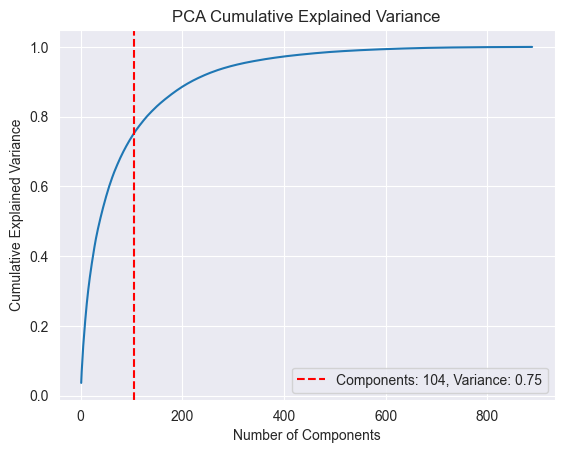

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
df['concat_diags'] = df['diag_1'].str.cat(df['diag_2'].str.cat(df['diag_3'], sep = ' '), sep=' ')
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['concat_diags'])

dense_tfidf_features = tfidf_features.toarray()  # or tfidf_features.todense()
pca = PCA()
pca.fit(dense_tfidf_features)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_above_75 = np.argmax(cumulative_variance >= 0.75) + 1
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)

# Highlight the point where cumulative variance exceeds 0.75
if num_components_above_75 > 0:
    plt.axvline(x=num_components_above_75, color='r', linestyle='--', label=f'Components: {num_components_above_75}, Variance: {cumulative_variance[num_components_above_75-1]:.2f}')
    plt.legend()
    
    
print(f"The number of components where cumulative variance is above 0.75: {num_components_above_75}")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')

plt.show()


In [8]:
pca = PCA(n_components=num_components_above_75)
embeddings = pca.fit_transform(dense_tfidf_features)
pca_columns = [f'diag_pca_{i+1}' for i in range(embeddings.shape[1])]

pca_df = pd.DataFrame(embeddings, columns=pca_columns)
df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)
df.drop(['diag_1',
         'diag_2',
         'diag_3',
         'concat_diags'], axis=1, inplace=True)

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_pca_95,diag_pca_96,diag_pca_97,diag_pca_98,diag_pca_99,diag_pca_100,diag_pca_101,diag_pca_102,diag_pca_103,diag_pca_104
0,149190,55629189,Caucasian,1,[10-20),1,1,7,3.0,0,...,0.001611,-0.002641,0.000131,0.019005,0.000311,0.001097,-0.015644,-0.006504,0.013285,-0.005864
1,64410,86047875,AfricanAmerican,1,[20-30),1,1,7,2.0,0,...,-0.036483,-0.029741,-0.029267,-0.158314,-0.029691,-0.007657,0.063141,0.042498,-0.098767,-0.075740
2,500364,82442376,Caucasian,0,[30-40),1,1,7,2.0,0,...,0.002229,-0.005320,0.002707,0.007985,-0.008404,0.001512,-0.007373,-0.006232,0.012768,-0.010828
3,16680,42519267,Caucasian,0,[40-50),1,1,7,1.0,0,...,-0.002626,-0.010034,0.000944,0.002959,0.027458,0.012830,-0.011225,0.000144,-0.018209,-0.001851
4,55842,84259809,Caucasian,0,[60-70),3,1,2,4.0,0,...,0.001874,0.002255,-0.002879,-0.003782,0.002977,-0.012647,0.007975,0.003687,0.003335,-0.002529


age feature, as it has a natural logical order will be encoded using ordinal encoder

In [9]:
df.sort_values(by=['age'])['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
age_orders = [sorted(df['age'].unique())]
ordinal_encoder = OrdinalEncoder(categories=age_orders)
df['age'] = ordinal_encoder.fit_transform(df[['age']])

Drug features (from metformin to metformin-pioglitazone) are more complex because each of them could take 4 possible values (up, down, steady and No). Additionally, there are drugs that are less common in patients and that we do not have examples of all possible values among this "rare" drug usage. These cases are clearer when we see the values they take, and we recognize an imbalance towards non-usage. This feature will only be noisy and won´t add information for the model, thus we discard them

In [11]:
drugs = ['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
drugs_val_count = dict()
for i in drugs:
    n = df[i].nunique()
    drugs_val_count[i] = n
    
drop_drugs=[]
for key, value in drugs_val_count.items():
    if value < 4:
        drop_drugs.append(key)
        print(df[key].value_counts(normalize=True))

df.drop(drop_drugs, axis=1,inplace=True)

acetohexamide
No    1.0
Name: proportion, dtype: float64
tolbutamide
No        0.999785
Steady    0.000215
Name: proportion, dtype: float64
troglitazone
No        0.999968
Steady    0.000032
Name: proportion, dtype: float64
tolazamide
No        0.999592
Steady    0.000398
Up        0.000011
Name: proportion, dtype: float64
examide
No    1.0
Name: proportion, dtype: float64
citoglipton
No    1.0
Name: proportion, dtype: float64
glipizide-metformin
No        0.99986
Steady    0.00014
Name: proportion, dtype: float64
glimepiride-pioglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64
metformin-rosiglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64
metformin-pioglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64


We have already encoded age, gender, medical_specialty, change and diabetesMed. admission_type_id, discharge_disposition_id and admission_source_id are already encoded so they do not need further manipulation. The encoding strategy for the rest of features will be based on the number of values each feature can take and of course the type of feature it is

In [12]:
df.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace=True)

num_columns = ['time_in_hospital', 
               'num_lab_procedures', 
               'num_procedures',
               'num_medications', 
               'number_outpatient', 
               'number_emergency',
               'number_inpatient', 
               'number_diagnoses']
diag_pca_columns = [col for col in df.columns if col.startswith('diag_pca')]
num_columns.extend(diag_pca_columns)
cat_columns = df.drop(num_columns,axis=1).columns
cat_columns_to_encode=df[cat_columns].drop(['age',
                                            'gender',
                                            'change',
                                            'medical_specialty',
                                            'diabetesMed',
                                            'admission_type_id',
                                            'discharge_disposition_id',
                                            'admission_source_id',
                                            'readmitted',
                                            'readmitted_general'], axis=1).columns

print(f'Features pending to encode: {cat_columns_to_encode}')

Features pending to encode: Index(['race', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'insulin', 'glyburide-metformin'],
      dtype='object')


We define the threshold of 4 maximum possible values in each feature to be one-hot encoded, if the number of labels is greater then we use impact encoding.

In [13]:
one_hot_columns=[]
impact_encode_columns=[]
for i in cat_columns_to_encode:
    n = df[i].nunique()
    if n <=4:
        one_hot_columns.append(i)
    else:
        impact_encode_columns.append(i)
        
print(one_hot_columns)
print(impact_encode_columns)

['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin']
['race']


In [14]:
#One hot encoding
df = pd.get_dummies(df, columns=one_hot_columns)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Steady,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up
0,Caucasian,1,1.0,1,1,7,3.0,0,59.0,0.0,...,False,False,False,False,False,True,False,True,False,False
1,AfricanAmerican,1,2.0,1,1,7,2.0,0,11.0,5.0,...,False,False,False,True,False,False,False,True,False,False
2,Caucasian,0,3.0,1,1,7,2.0,0,44.0,1.0,...,False,False,False,False,False,True,False,True,False,False
3,Caucasian,0,4.0,1,1,7,1.0,0,51.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,Caucasian,0,6.0,3,1,2,4.0,0,70.0,1.0,...,False,False,False,False,True,False,False,True,False,False


Train/test split must be done before applying impact encoding as the values that will be mapped to the categorical features can only be computed with training labels. We also have to separate the data that will be used for the readmission type model (<30 or >30) as the features depend on the target and this "submodel" target is different from the general one (readmission or no readmission).

In [15]:
encode = {2: 0,
          1: 1}
df['readmitted_type'] = df['readmitted'].map(encode)
df['readmitted_type'] = df['readmitted_type'].astype('Int64')

**Train/test split**</br>

The selected training size is 85% vs 15% for testing. The test set will be only used for **final predictions**, i.e. the final predicted label (3 classess). Additional splits are performed within the training set for the two individual models.

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df.copy(), train_size = 0.85, random_state=7)
train_model1, test_model1 = train_test_split(train, train_size = 0.9, random_state=7)
train_readmission = train[(train['readmitted_general'] == 1)]
train_model2, test_model2 = train_test_split(train_readmission, train_size = 0.8, random_state=7)
print(f'Overall train size = {train.shape[0]}')
print(f'Overall test size = {test.shape[0]}')
print(f'Train size for  Readmission vs No Readmission model = {train_model1.shape[0]}')
print(f'Test size for Readmission vs No Readmission model = {test_model1.shape[0]}')
print(f'Train size for Type of Readmission model = {train_model2.shape[0]}')
print(f'Test size for Type of Readmission model = {test_model2.shape[0]}')

Overall train size = 79113
Overall test size = 13962
Train size for  Readmission vs No Readmission model = 71201
Test size for Readmission vs No Readmission model = 7912
Train size for Type of Readmission model = 29378
Test size for Type of Readmission model = 7345


In [17]:
test.to_csv(r'../data/processed/final_test_set.csv', index=False)
train_model1.to_csv(r'../data/interim/model1_train_set_wo_impact_encoding.csv', index=False)
train_model2.to_csv(r'../data/interim/model2_train_set_wo_impact_encoding.csv', index=False)

In [18]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

if module_path not in sys.path:
    sys.path.append(module_path)

from data_processing_pipeline import impact_encoding_model1, impact_encoding_model2
        
for dframe in [train_model1, test_model1]:
    impact_encoding_model1(dframe)
    
for dframe in [train_model2, test_model2]:
    impact_encoding_model1(dframe)

In [19]:
train_model1.to_csv(r'../data/processed/model1_train_set.csv', index=False)
train_model2.to_csv(r'../data/processed/model2_train_set.csv', index=False)
test_model1.to_csv(r'../data/processed/model1_test_set.csv', index=False)
test_model2.to_csv(r'../data/processed/model2_test_set.csv', index=False)

## Feature Scaling
Standard scaler was done for both models datasets

In [20]:
from data_processing_pipeline import scaler1, scaler2

#We drop the readmitted columns that have nothing to do with each model
train_model1.drop(['readmitted','readmitted_type'], axis=1,inplace=True)
test_model1.drop(['readmitted','readmitted_type'], axis=1,inplace=True)
train_model2.drop(['readmitted','readmitted_general'], axis=1,inplace=True)
test_model2.drop(['readmitted','readmitted_general'], axis=1,inplace=True)

# Target variables are not scaled
no_scale_model1 = ['readmitted_general']
no_scale_model2 = ['readmitted_type']

#Defining feature columns
features_model1 = train_model1.drop(no_scale_model1, axis=1).columns
features_model2 = train_model2.drop(no_scale_model2, axis=1).columns

#Applying scalers
train_model1_scaled = scaler1.transform(train_model1[features_model1])
test_model1_scaled = scaler1.transform(test_model1[features_model1])
train_model2_scaled = scaler2.transform(train_model2[features_model2])
test_model2_scaled = scaler2.transform(test_model2[features_model2])

#Returning to dfs
train_model1_scaled = pd.DataFrame(train_model1_scaled, columns=features_model1)
test_model1_scaled = pd.DataFrame(test_model1_scaled, columns=features_model1)
train_model2_scaled = pd.DataFrame(train_model2_scaled, columns=features_model2)
test_model2_scaled = pd.DataFrame(test_model2_scaled, columns=features_model2)

# Assign the values from the original DataFrames targets
# And explicitly set the data type to match the original DataFrames

for col in no_scale_model1:
    train_model1_scaled[col] = train_model1[col].values.astype(train_model1[col].dtype)
    test_model1_scaled[col] = test_model1[col].values.astype(test_model1[col].dtype)
    
for col in no_scale_model2:
    train_model2_scaled[col] = train_model2[col].values.astype(train_model2[col].dtype)
    test_model2_scaled[col] = test_model2[col].values.astype(test_model2[col].dtype)

In [21]:
train_model1_scaled.to_csv(r'../data/processed/model1_train_set_scaled.csv',index=False)
train_model2_scaled.to_csv(r'../data/processed/model2_train_set_scaled.csv',index=False)
test_model1_scaled.to_csv(r'../data/processed/model1_test_set_scaled.csv',index=False)
test_model2_scaled.to_csv(r'../data/processed/model2_test_set_scaled.csv',index=False)